# 観測データと背景知識に基づく応用一般均衡モデル生産サイド（縮約版成長回帰モデル）構造の自動生成
因果探索と論理整合性検証によるモデル構造のデータ駆動的構築：ブーリアンルールと最適化モデルの統合

1. 観測データから因果探索
- 実データを用いて DirectLiNGAM などで因果構造を抽出
- ブーリアンルール（if A then B）として表現

2. LLMを用いた背景知識の獲得
- ノード間の意味的関係（例：「GDPが高いなら労働力も高い」など）を自然言語で取得
- 背景知識もブーリアンルールに変換

3. 観測ルール × 背景ルールの整合性評価
- Answer Set Programming（ASP）を用い、充足可能性を確認
- 競合ルール（矛盾）を自動検出 → 排除

4. データ駆動ルールによる構造式定義
- 使用可能な観測由来ルールから、CGEモデルの生産関数の因果構造を生成
- 各式の係数（β）は実データから推定（回帰分析）

5. コブダグラス生産関数によるマクロ的統合
- 回帰式をネストし、CGEモデルの生産関数を形成
- GAMSpyにより最適化モデルとして構築・解く

## 準備

- Ollamaをダウンロードする
https://ollama.com/download
- ターミナルで以下実行する（モデルがダウンロードされ、Ollamaがバックグラウンドで起動する）
ollama run mistral

- GraphvizをダウンロードしPATHを通す https://graphviz.org/download/

In [7]:
# 設定読み込み
import sys
import yaml
sys.path.append("scripts")
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [8]:
import importlib
import fetch_wbdata, causal_graph, rule_extractor, rule_converter, background_knowledge, asp_generator, infer_hypotheses, cge_model
importlib.reload(fetch_wbdata)
importlib.reload(causal_graph)
importlib.reload(rule_extractor)
importlib.reload(rule_converter)
importlib.reload(background_knowledge)
importlib.reload(asp_generator)
importlib.reload(infer_hypotheses)
importlib.reload(cge_model)

<module 'cge_model' from 'C:\\Users\\user\\OneDrive\\Desktop\\seeps2025\\scripts\\cge_model.py'>

In [9]:
from fetch_wbdata import fetch_worldbank_data
from causal_graph import estimate_and_plot_causal_graph, plot_causal_graph_from_rules
from rule_extractor import extract_boolean_rules 
from rule_converter import rule_to_asp_program
from background_knowledge import extract_background_rules # Ollamaが起動している状態で実行
from asp_generator import rule_to_asp
from infer_hypotheses import run_clingo, check_satisfiability, detect_conflicts, remove_conflicting_data_rules
from cge_model import build_custom_nested_cge_model, generate_latex_equations_with_coefficients, estimate_alpha_and_build_cd_model_constrained

## 観測データからの因果探索

In [10]:
df = fetch_worldbank_data("config.yaml")

🔄 Fetching data from World Bank...
✅ Data saved to: data/cge_base_data.csv


In [11]:
df.head()

,Country,Year,GDP (current US$),Gross capital formation (% of GDP),Exports of goods and services (% of GDP),Imports of goods and services (% of GDP),Unemployment rate (%),Total labor force,CO2 emissions per capita,Renewable energy consumption (% of total final energy consumption),Energy use per capita (kg of oil equivalent)
0,Brazil,2010,2.208838e+12,21.801322,10.865585,11.906593,8.422,96467543.0,2.270341,46.8,1381.001236
1,Brazil,2011,2.616156e+12,21.826271,11.582513,12.351892,7.578,95987652.0,2.373464,45.2,1386.561240
2,Brazil,2012,2.465228e+12,21.417225,11.877539,13.236735,7.251,96690220.0,2.528103,43.5,1429.552350
3,Brazil,2013,2.472820e+12,21.693767,11.742231,14.043727,7.071,97945820.0,2.636097,42.3,1483.682318
4,Brazil,2014,2.456044e+12,20.548411,11.011943,13.673463,6.755,98901551.0,2.729587,41.7,1517.770555


Graphviz layout failed (dot overflow?), falling back to spring layout.


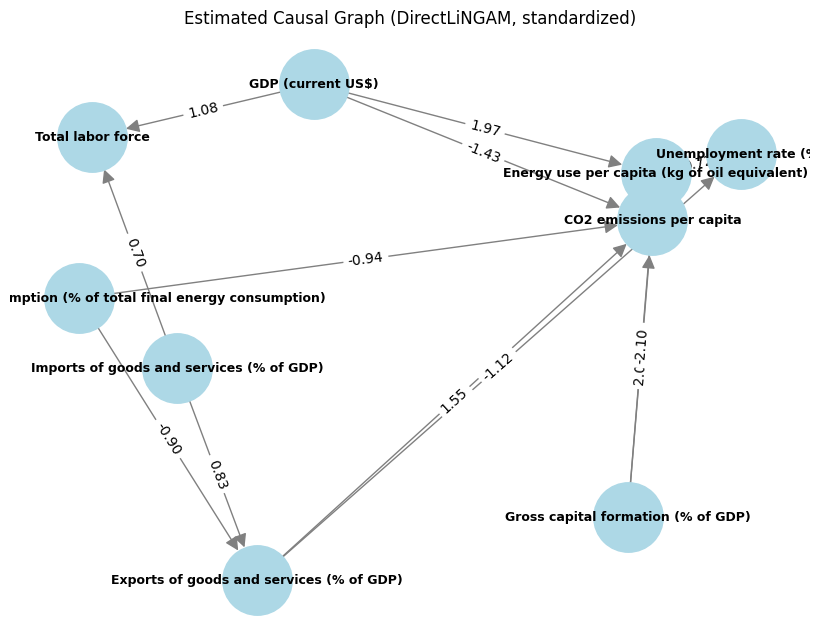

✅ エッジ情報を data/causal_graph_edges.csv に保存しました。


In [12]:
# 因果グラフ生成
G, adj_matrix = estimate_and_plot_causal_graph(config["causal"])

## 観測データ由来のブーリアンルールを抽出し保存

In [13]:
# ルール抽出
rules = extract_boolean_rules(G, df, threshold_mode=config["rule_extractor"]["threshold_mode"])

# ルール表示
for rule in rules:
    print(rule)

IF GDP (current US$) > 1115666684419.25 THEN Total labor force ↑
IF GDP (current US$) > 1115666684419.25 THEN CO2 emissions per capita ↓
IF GDP (current US$) > 1115666684419.25 THEN Energy use per capita (kg of oil equivalent) ↓
IF Gross capital formation (% of GDP) > 22.17 THEN CO2 emissions per capita ↓
IF Gross capital formation (% of GDP) > 22.17 THEN Energy use per capita (kg of oil equivalent) ↓
IF Exports of goods and services (% of GDP) > 21.41 THEN Unemployment rate (%) ↑
IF Exports of goods and services (% of GDP) > 21.41 THEN CO2 emissions per capita ↑
IF Imports of goods and services (% of GDP) > 24.52 THEN Exports of goods and services (% of GDP) ↑
IF Imports of goods and services (% of GDP) > 24.52 THEN Total labor force ↓
IF CO2 emissions per capita > 2.25 THEN Energy use per capita (kg of oil equivalent) ↑
IF Renewable energy consumption (% of total final energy consumption) > 32.70 THEN Exports of goods and services (% of GDP) ↓
IF Renewable energy consumption (% of to

In [14]:
asp_program = rule_to_asp_program(rules)

print("=== ASP Program Rules ===")
with open("rules/data_rules.lp",mode="w",encoding="utf-8") as f:
    for r in asp_program:
        print(r)    
        f.write(r+"\n")

=== ASP Program Rules ===
total_labor_force_high :- gdp_current_us_high.
co2_emissions_per_capita_high :- not gdp_current_us_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- not gdp_current_us_high.
co2_emissions_per_capita_high :- not gross_capital_formation_of_gdp_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- not gross_capital_formation_of_gdp_high.
unemployment_rate_high :- exports_of_goods_and_services_of_gdp_high.
co2_emissions_per_capita_high :- exports_of_goods_and_services_of_gdp_high.
exports_of_goods_and_services_of_gdp_high :- imports_of_goods_and_services_of_gdp_high.
total_labor_force_high :- not imports_of_goods_and_services_of_gdp_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- co2_emissions_per_capita_high.
exports_of_goods_and_services_of_gdp_high :- not renewable_energy_consumption_of_total_final_energy_consumption_high.
co2_emissions_per_capita_high :- not renewable_energy_consumption_of_total_final_energy_consumption_high.
unemployment_ra

## 背景知識由来のブーリアンルールをLLMで自動生成し保存

In [15]:
# 例として簡単な因果グラフを作成
import networkx as nx
# 背景知識の抽出（Ollamaで経済社会的背景を推定）
rules = extract_background_rules(G) # rulesは既存のbackground_rules.lpになく、新たに抽出された知識

print("==== Newly added ====")
with open("rules/background_rules.lp",mode="a",encoding="utf-8") as f:
    for r in rules:
        print(r)
        f.write(r+"\n")

  0%|          | 0/9 [00:00<?, ?it/s]

checking...
['gdp_current_us_high', 'gross_capital_formation_of_gdp_high']
asp_rule exists:  gross_capital_formation_of_gdp_high :- gdp_current_us_high.
checking...
['gdp_current_us_high', 'exports_of_goods_and_services_of_gdp_high']
asp_rule exists:  exports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
checking...
['gdp_current_us_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule exists:  imports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
checking...
['gdp_current_us_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- gdp_current_us_low.
checking...
['gdp_current_us_high', 'total_labor_force_high']
asp_rule exists:  total_labor_force_high :- gdp_current_us_high.
checking...
['gdp_current_us_high', 'co2_emissions_per_capita_high']
asp_rule exists:  co2_emissions_per_capita_high :- gdp_current_us_high.
checking...
['gdp_current_us_high', 'renewable_energy_consumption_of_total_final_energy_consumption_high']
checking...
['gd

 11%|█         | 1/9 [01:34<12:34, 94.27s/it]

asp_rule exists:  energy_use_per_capita_kg_of_oil_equivalent_high :- gdp_current_us_high.
checking...
['gross_capital_formation_of_gdp_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- gross_capital_formation_of_gdp_high.
checking...
['gross_capital_formation_of_gdp_high', 'exports_of_goods_and_services_of_gdp_high']
asp_rule exists:  exports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
checking...
['gross_capital_formation_of_gdp_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule exists:  imports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
checking...
['gross_capital_formation_of_gdp_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- gross_capital_formation_of_gdp_high.
checking...
['gross_capital_formation_of_gdp_high', 'co2_emissions_per_capita_high']
asp_rule exists:  co2_emissions_per_capita_high :- gross_capital_formation_of_gdp_high.
checking...
['gross_capital_for

 22%|██▏       | 2/9 [03:29<12:26, 106.58s/it]

asp_rule exists:  energy_use_per_capita_kg_of_oil_equivalent_high :- gross_capital_formation_of_gdp_high.
checking...
['exports_of_goods_and_services_of_gdp_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- exports_of_goods_and_services_of_gdp_high.
checking...
['exports_of_goods_and_services_of_gdp_high', 'gross_capital_formation_of_gdp_high']
asp_rule exists:  gross_capital_formation_of_gdp_high :- exports_of_goods_and_services_of_gdp_high.
checking...
['exports_of_goods_and_services_of_gdp_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule exists:  imports_of_goods_and_services_of_gdp_high :- exports_of_goods_and_services_of_gdp_high.
checking...
['exports_of_goods_and_services_of_gdp_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- exports_of_goods_and_services_of_gdp_high.
checking...
['exports_of_goods_and_services_of_gdp_high', 'total_labor_force_high']
asp_rule exists:  total_labor_force_high :- exports_of_goods_and_ser

 33%|███▎      | 3/9 [05:49<12:12, 122.04s/it]

checking...
['imports_of_goods_and_services_of_gdp_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- imports_of_goods_and_services_of_gdp_high.
checking...
['imports_of_goods_and_services_of_gdp_high', 'gross_capital_formation_of_gdp_high']
checking...
['imports_of_goods_and_services_of_gdp_high', 'exports_of_goods_and_services_of_gdp_high']
asp_rule exists:  exports_of_goods_and_services_of_gdp_high :- imports_of_goods_and_services_of_gdp_high.
checking...
['imports_of_goods_and_services_of_gdp_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- imports_of_goods_and_services_of_gdp_high.
checking...
['imports_of_goods_and_services_of_gdp_high', 'co2_emissions_per_capita_high']
checking...
['imports_of_goods_and_services_of_gdp_high', 'renewable_energy_consumption_of_total_final_energy_consumption_high']


 44%|████▍     | 4/9 [07:43<09:53, 118.66s/it]

checking...
['unemployment_rate_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- unemployment_rate_high.
checking...
['unemployment_rate_high', 'gross_capital_formation_of_gdp_high']
asp_rule exists:  gross_capital_formation_of_gdp_high :- unemployment_rate_high.
checking...
['unemployment_rate_high', 'exports_of_goods_and_services_of_gdp_high']
asp_rule does not exist.
checking...
['unemployment_rate_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule does not exist.
checking...
['unemployment_rate_high', 'total_labor_force_high']
asp_rule exists:  total_labor_force_high :- unemployment_rate_high.
checking...
['unemployment_rate_high', 'co2_emissions_per_capita_high']
asp_rule exists:  co2_emissions_per_capita_high :- unemployment_rate_high.
checking...
['unemployment_rate_high', 'renewable_energy_consumption_of_total_final_energy_consumption_high']
checking...
['unemployment_rate_high', 'energy_use_per_capita_kg_of_oil_equivalent_high']


 56%|█████▌    | 5/9 [09:59<08:20, 125.02s/it]

asp_rule exists:  energy_use_per_capita_kg_of_oil_equivalent_high :- unemployment_rate_high.
checking...
['total_labor_force_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- total_labor_force_high.
checking...
['total_labor_force_high', 'gross_capital_formation_of_gdp_high']
asp_rule exists:  gross_capital_formation_of_gdp_high :- total_labor_force_high.
checking...
['total_labor_force_high', 'exports_of_goods_and_services_of_gdp_high']
checking...
['total_labor_force_high', 'imports_of_goods_and_services_of_gdp_high']
checking...
['total_labor_force_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- total_labor_force_high.
checking...
['total_labor_force_high', 'co2_emissions_per_capita_high']
asp_rule does not exist.
checking...
['total_labor_force_high', 'renewable_energy_consumption_of_total_final_energy_consumption_high']


 67%|██████▋   | 6/9 [12:26<06:36, 132.32s/it]

asp_rule exists:  renewable_energy_consumption_of_total_final_energy_consumption_high :- total_labor_force_high.
checking...
['co2_emissions_per_capita_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- co2_emissions_per_capita_high.
checking...
['co2_emissions_per_capita_high', 'exports_of_goods_and_services_of_gdp_high']
checking...
['co2_emissions_per_capita_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- co2_emissions_per_capita_high.
checking...
['co2_emissions_per_capita_high', 'total_labor_force_high']
checking...
['co2_emissions_per_capita_high', 'renewable_energy_consumption_of_total_final_energy_consumption_high']
asp_rule exists:  renewable_energy_consumption_of_total_final_energy_consumption_high :- co2_emissions_per_capita_high.
checking...
['co2_emissions_per_capita_high', 'energy_use_per_capita_kg_of_oil_equivalent_high']


 78%|███████▊  | 7/9 [14:33<04:21, 130.55s/it]

asp_rule exists:  energy_use_per_capita_kg_of_oil_equivalent_high :- co2_emissions_per_capita_high.
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'gdp_current_us_high']
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'gross_capital_formation_of_gdp_high']
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'exports_of_goods_and_services_of_gdp_high']
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule does not exist.
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- renewable_energy_consumption_of_total_final_energy_consumption_high.
checking...
['renewable_energy_consumption_of_total_final_energy_consumption_high', 'total_labor_force_high']
checking...
['renewable_energy_consumption_of_total_fi

 89%|████████▉ | 8/9 [16:59<02:15, 135.61s/it]

asp_rule exists:  energy_use_per_capita_kg_of_oil_equivalent_high :- renewable_energy_consumption_of_total_final_energy_consumption_high.
checking...
['energy_use_per_capita_kg_of_oil_equivalent_high', 'gdp_current_us_high']
asp_rule exists:  gdp_current_us_high :- energy_use_per_capita_kg_of_oil_equivalent_high.
checking...
['energy_use_per_capita_kg_of_oil_equivalent_high', 'gross_capital_formation_of_gdp_high']
asp_rule does not exist.
checking...
['energy_use_per_capita_kg_of_oil_equivalent_high', 'exports_of_goods_and_services_of_gdp_high']
asp_rule does not exist.
checking...
['energy_use_per_capita_kg_of_oil_equivalent_high', 'imports_of_goods_and_services_of_gdp_high']
asp_rule exists:  imports_of_goods_and_services_of_gdp_high :- energy_use_per_capita_kg_of_oil_equivalent_high.
checking...
['energy_use_per_capita_kg_of_oil_equivalent_high', 'unemployment_rate_high']
asp_rule exists:  unemployment_rate_high :- energy_use_per_capita_kg_of_oil_equivalent_high.
checking...
['energ

100%|██████████| 9/9 [19:09<00:00, 127.74s/it]

asp_rule exists:  co2_emissions_per_capita_high :- energy_use_per_capita_kg_of_oil_equivalent_high.
==== Newly added ====
gross_capital_formation_of_gdp_high :- gdp_current_us_high.
exports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
imports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
unemployment_rate_high :- not gdp_current_us_high.
total_labor_force_high :- gdp_current_us_high.
co2_emissions_per_capita_high :- gdp_current_us_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- gdp_current_us_high.
gdp_current_us_high :- gross_capital_formation_of_gdp_high.
exports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
imports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
unemployment_rate_high :- gross_capital_formation_of_gdp_high.
co2_emissions_per_capita_high :- gross_capital_formation_of_gdp_high.
renewable_energy_consumption_of_total_final_energy_consumption_high :- gross_capital_formation_of_gdp_hig

## 観測データ由来のブーリアンルールと背景知識由来のブーリアンルールをもとに解集合プログラミング

In [16]:
# 充足可能性判定
data_rules = []
with open("rules/data_rules.lp") as f:
    line = f.readline()[:-1]
    while line:
        data_rules.append(line)
        line = f.readline()[:-1]

background_rules = []
with open("rules/background_rules.lp") as f:
    line = f.readline()[:-1]
    while line:
        background_rules.append(line)
        line = f.readline()[:-1]

check_satisfiability(data_rules, background_rules, verbose=True)

=== ASP プログラム ===
gross_capital_formation_of_gdp_high :- gdp_current_us_high.
exports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
imports_of_goods_and_services_of_gdp_high :- gdp_current_us_high.
tax_revenue_of_gdp_high :- gdp_current_us_high.
total_labor_force_high :- gdp_current_us_high.
co2_emissions_per_capita_high :- gdp_current_us_high.
renewable_energy_consumption_of_total_final_energy_consumption_high :- gdp_current_us_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- gdp_current_us_high.
gdp_current_us_high :- gross_capital_formation_of_gdp_high.
exports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
imports_of_goods_and_services_of_gdp_high :- gross_capital_formation_of_gdp_high.
tax_revenue_of_gdp_high :- gross_capital_formation_of_gdp_high.
co2_emissions_per_capita_high :- gross_capital_formation_of_gdp_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- gross_capital_formation_of_gdp_high.
gdp_current_us_high :- exports_

(False, [])

In [17]:
# 矛盾するルールの検出
conflicts = detect_conflicts(data_rules, background_rules)
for i, (d_rule, b_rule) in enumerate(conflicts, 1):
    print(f"\nConflict #{i}:")
    print(f"  [Data]       {d_rule[1]} :- {', '.join(d_rule[2])}")
    print(f"  [Background] {b_rule[1]} :- {', '.join(b_rule[2])}")


Conflict #1:
  [Data]       co2_emissions_per_capita_high :- not gdp_current_us_high
  [Background] co2_emissions_per_capita_high :- gdp_current_us_high

Conflict #2:
  [Data]       co2_emissions_per_capita_high :- not gdp_current_us_high
  [Background] co2_emissions_per_capita_high :- gdp_current_us_high

Conflict #3:
  [Data]       energy_use_per_capita_kg_of_oil_equivalent_high :- not gdp_current_us_high
  [Background] energy_use_per_capita_kg_of_oil_equivalent_high :- gdp_current_us_high

Conflict #4:
  [Data]       energy_use_per_capita_kg_of_oil_equivalent_high :- not gdp_current_us_high
  [Background] energy_use_per_capita_kg_of_oil_equivalent_high :- gdp_current_us_high

Conflict #5:
  [Data]       co2_emissions_per_capita_high :- not gross_capital_formation_of_gdp_high
  [Background] co2_emissions_per_capita_high :- gross_capital_formation_of_gdp_high

Conflict #6:
  [Data]       co2_emissions_per_capita_high :- not gross_capital_formation_of_gdp_high
  [Background] co2_emiss

In [18]:
cleaned, removed = remove_conflicting_data_rules(data_rules, background_rules)

# === 結果出力 ===
print("=== 使用可能な観測ルール ===")
with open("rules/cleaned_data_rules.lp",mode="w",encoding="utf-8") as f:
    for rule in cleaned:
        f.write(rule+"\n")
        print(rule)

print("\n=== 削除された矛盾ルール ===")
for rule in removed:
    print(rule)

=== 使用可能な観測ルール ===
total_labor_force_high :- gdp_current_us_high.
unemployment_rate_high :- exports_of_goods_and_services_of_gdp_high.
co2_emissions_per_capita_high :- exports_of_goods_and_services_of_gdp_high.
exports_of_goods_and_services_of_gdp_high :- imports_of_goods_and_services_of_gdp_high.
total_labor_force_high :- not imports_of_goods_and_services_of_gdp_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- co2_emissions_per_capita_high.
exports_of_goods_and_services_of_gdp_high :- not renewable_energy_consumption_of_total_final_energy_consumption_high.
co2_emissions_per_capita_high :- not renewable_energy_consumption_of_total_final_energy_consumption_high.
unemployment_rate_high :- energy_use_per_capita_kg_of_oil_equivalent_high.

=== 削除された矛盾ルール ===
co2_emissions_per_capita_high :- not gdp_current_us_high.
energy_use_per_capita_kg_of_oil_equivalent_high :- not gdp_current_us_high.
co2_emissions_per_capita_high :- not gross_capital_formation_of_gdp_high.
energy_use_per_capi

In [19]:
results = run_clingo("rules/background_rules.lp", "rules/cleaned_data_rules.lp", "rules/infer_hypotheses.lp")
for r in results:
    print("Answer Set:", r)

## 使用可能な観測データ由来のブーリアンルールをもとにCGEモデルを構築＆係数推定

In [20]:
cleaned_data_rules = []
with open("rules/cleaned_data_rules.lp") as f:
    line = f.readline()[:-1]
    while line:
        cleaned_data_rules.append(line)
        line = f.readline()[:-1]

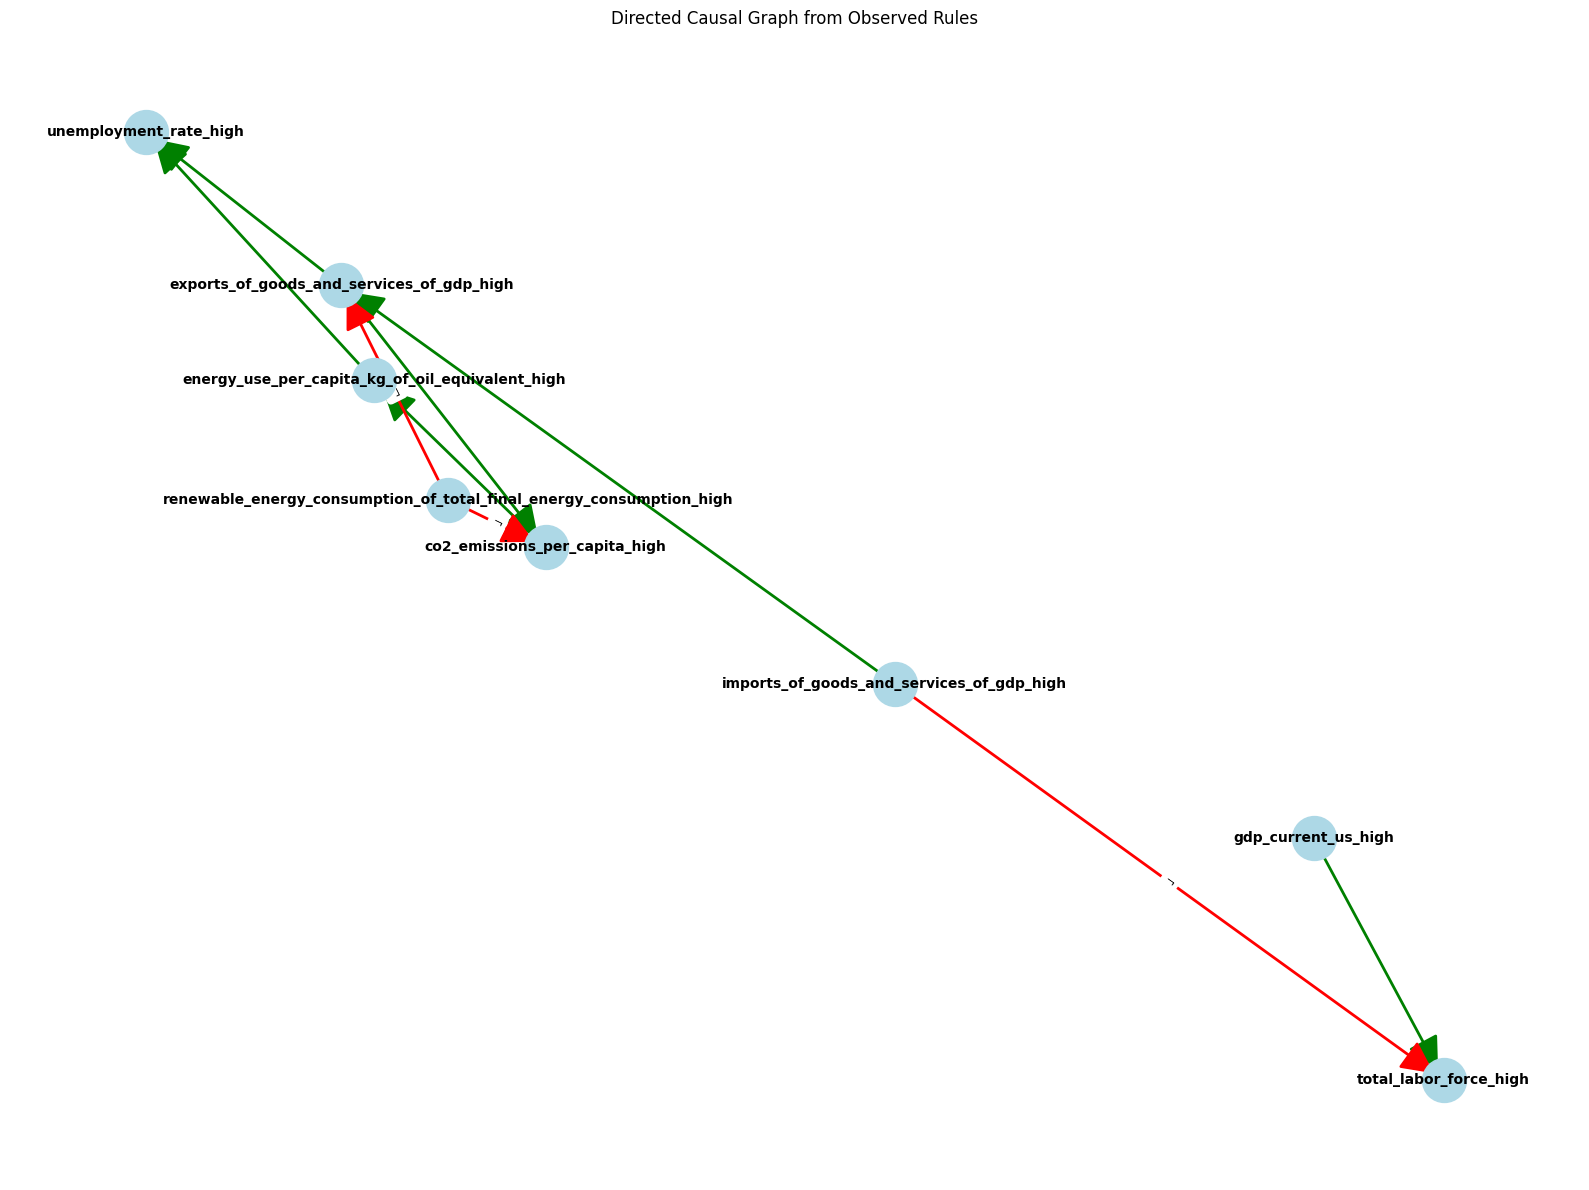

✅ エッジ情報を data/causal_graph_edges_cleaned.csv に保存しました。


In [21]:
# 使用可能な観測ルールから因果グラフに戻す
plot_causal_graph_from_rules(cleaned_data_rules)

In [29]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
def standardize_dataframe(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    scaler = StandardScaler()
    df_standardized = df.copy()
    df_standardized[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    return df_standardized

############################
# Human manipulation 
############################
df_for_cge = pd.DataFrame({
    "unemployment_rate_high": pd.Series(df["Unemployment rate (%)"]),
    "gdp_current_us_high":pd.Series(df["GDP (current US$)"]),
    "exports_of_goods_and_services_of_gdp_high":pd.Series(df["Exports of goods and services (% of GDP)"]),
    "gross_capital_formation_of_gdp_high":pd.Series(df["Gross capital formation (% of GDP)"]),
    "imports_of_goods_and_services_of_gdp_high":pd.Series(df["Imports of goods and services (% of GDP)"]),
    # "household_final_consumption_of_gdp_high":pd.Series(df["Household final consumption (% of GDP)"]),
    "total_labor_force_high":pd.Series(df["Total labor force"]),
    #"tax_revenue_of_gdp_high":pd.Series(df["Tax revenue (% of GDP)"]),
    "co2_emissions_per_capita_high":pd.Series(df["CO2 emissions per capita"]),
    "renewable_energy_consumption_of_total_final_energy_consumption_high":pd.Series(df["Renewable energy consumption (% of total final energy consumption)"]),
    # "pm2.5_air_pollution_micrograms_per_cubic_meter_high":pd.Series(df["PM2.5 air pollution (micrograms per cubic meter)"]),
    "energy_use_per_capita_kg_of_oil_equivalent_high": pd.Series(df["Energy use per capita (kg of oil equivalent)"])
})

df_for_cge = standardize_dataframe(df_for_cge)
df_for_cge.head()

,unemployment_rate_high,gdp_current_us_high,exports_of_goods_and_services_of_gdp_high,gross_capital_formation_of_gdp_high,imports_of_goods_and_services_of_gdp_high,total_labor_force_high,co2_emissions_per_capita_high,renewable_energy_consumption_of_total_final_energy_consumption_high,energy_use_per_capita_kg_of_oil_equivalent_high
0,-0.122786,1.222402,-1.457882,-0.367423,-1.696152,-0.247808,-0.330706,0.655971,0.313978
1,-0.225453,1.703085,-1.367196,-0.363928,-1.637550,-0.250650,-0.289526,0.581827,0.322789
2,-0.265231,1.524972,-1.329878,-0.421233,-1.521104,-0.246490,-0.227773,0.503049,0.390913
3,-0.287127,1.533931,-1.346993,-0.382491,-1.414902,-0.239056,-0.184648,0.447441,0.476689
4,-0.325566,1.514134,-1.439369,-0.542948,-1.463630,-0.233397,-0.147314,0.419636,0.530706


回帰式の目的変数
"total_labor_force_high",
"tax_revenue_of_gdp_high", 
"gross_capital_formation_of_gdp_high"

メインのコブダグラス生産関数
"capital :- tax_revenue_of_gdp_high, gross_capital_formation_of_gdp_high.",
"labor :- total_labor_force_high.",
"gdp_current_us_high :- capital, labor."

In [30]:
############################
# Human manipulation 
############################
# 回帰の目的変数
regression_targets = [
    "total_labor_force_high",
    # "tax_revenue_of_gdp_high",
    "gross_capital_formation_of_gdp_high"
]
# Cobb-Douglasの構造ルール
main_structure_rules = [
    # "capital :- tax_revenue_of_gdp_high, gross_capital_formation_of_gdp_high.",
    "capital :- gross_capital_formation_of_gdp_high.",
    "labor :- total_labor_force_high.",
    "labor :- not unemployment_rate_high.",
    "gdp_current_us_high :- capital, labor."
]

In [31]:
container = build_custom_nested_cge_model(cleaned_data_rules, df_for_cge, regression_targets, main_structure_rules)
container.write("data/cge_model.gdx")  # GAMSコードとして出力

  Solver Status Model Status     Objective  Num of Equations  \
0        Normal    Unbounded  7.351596e+26                 3   

   Num of Variables Model Type  Solver  Solver Time  
0                 5        NLP  IPOPTH        0.003  
⚠️ Skipping 'uni': not a Variable object.
⚠️ Skipping 'capital': not a Variable object.
⚠️ Skipping 'total_labor_force_high': not a Variable object.
⚠️ Skipping 'gdp_current_us_high': not a Variable object.
⚠️ Skipping 'element_text': not a Variable object.
⚠️ Skipping 'labor': not a Variable object.
Empty DataFrame
Columns: []
Index: []


In [32]:
# nested CGEモデルの数式表示
generate_latex_equations_with_coefficients(
    rules=cleaned_data_rules,
    regression_targets=[
        "total_labor_force_high",
        # "tax_revenue_of_gdp_high",
        "gross_capital_formation_of_gdp_high"
    ],
    main_structure_rules=[
        "capital :- tax_revenue_of_gdp_high, gross_capital_formation_of_gdp_high.",
        "labor :- total_labor_force_high.",
        "labor :- not unemployment_rate_high.",
        "gdp_current_us_high :- capital, labor."
    ],
    df=df_for_cge, 
    main_output="gdp_current_us_high"
)

⚠️ Skipping regression for gross_capital_formation_of_gdp_high due to empty data.


$$\text{total\_labor\_force\_high} = 0.00 + 0.12 \cdot (1 - imports\_of\_goods\_and\_services\_of\_gdp\_high) + 0.75 \cdot gdp\_current\_us\_high$$

$$\text{gdp\_current\_us\_high} = A \cdot (\text{capital})^{\alpha_{1}} \cdot (\text{labor})^{\alpha_{2}}$$

## αの推定

In [33]:
###############################
# Human manipulation
###############################
# df_for_estimate_alpha = pd.DataFrame({
#     "capital": 0.42*df_for_cge["gdp_current_us_high"]+0.77*df_for_cge["gross_capital_formation_of_gdp_high"]+0.22*(1-df_for_cge['tax_revenue_of_gdp_high']),
#     "labor": -0.61*(1-df_for_cge['gross_capital_formation_of_gdp_high']),
#     "gdp": df_for_cge["gdp_current_us_high"]
# })
# 正規化されたα: {'capital': 1.6107138167815778, 'labor': -0.6107138167815777}

df_for_estimate_alpha = pd.DataFrame({
    "capital": df_for_cge['gross_capital_formation_of_gdp_high'],
    "labor": 0.12*(1-df_for_cge['imports_of_goods_and_services_of_gdp_high'])+0.75*df_for_cge['gdp_current_us_high'],
    "gdp": df_for_cge["gdp_current_us_high"]
})

In [34]:
model, alpha_values = estimate_alpha_and_build_cd_model_constrained(
    df_for_estimate_alpha, output_var="gdp", input_vars=["capital", "labor"]
)
print("正規化されたα:", alpha_values)

正規化されたα: {'capital': 0.3761420220728869, 'labor': 0.6238579752898257}


C:\Users\user\anaconda3\envs\seeps2025\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\user\anaconda3\envs\seeps2025\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
